# Lab 3: Bias-Variance Decomposition

In prior labs we've looked at errors made by our classifiers, and considered the
way these mistakes might impact groups we care about in our data. In this lab,
we will explore more to understand these errors with respect to models that
have been seen previously, and assess how changes in hyperparameters in our
models can affect these errors. We will continue to use the NHANES dataset.

Two major sources of error that we can, in theory, work to control
are **bias** and **variance**. As you learned in class, bias occurs
when our predictions reflect underlying assumptions about our model,
regardless of the training data. For example, if we are making predictions
using a linear regression model, we must assume linearity between our input
features and our target. But relationships between features and targets
are often far from linear. This means that if our model is constrained
to make linear predictions when true relationships between features and
targets are non-linear, our predictions will be biased in favour of our
modelling assumptions.

On the other hand, it might be the case that we train a model that very
accurately captures the relationship between our features and target
in a small set of training data. While this might seem desirable, if
our training data does not reflect our test data, our model may not
reflect relationships between the features and target in test data.
This source of error is due the fact that we have tailored our model
to capture relationships in a small, but non-representative, set of
data. If we have this kind of a variance issue, our model may end up
being very sensitive to small fluctuations in the training set that we
choose.

Ideally, we want to reduce **both** sources of error. If we manage to
reduce both, then we can build more accurate models. But how do we
diagnose bias and variance issues in the first place?  And what should
we do about the issues? And how can we be sure that our "fixes"
mitigate the risks that might be associated with our model's use?

By the end of this lab you will be able to:

1. How to assess bias and variance in errors in a synthetic regression and
   real-world classification example;
2. How bias and variance can be related to model complexity;
3. How bias and variance can be related to choices of features;
4. Some of the limitations to analyses of bias and variance, in particular as related to risk.

Thanks to https://www.kaggle.com/code/tobyanderson/health-survey-analysis for some utilities to decode NHANES categories!  

## Google Colab Setup

As before, we will import `matplotlib`, `numpy`, and `pandas` for plotting, linear algebra manipulations, and manipulating tabular data.

In [1]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # Linear algebra library
import pandas as pd             # For manipulating tabular data
import random                   # for random number generation

## Part 1. Synthetic Data Demonstration

In this section, we will study bias and variance in some synthetic data
so that we can control the way that data is generated, so the data generation
distribution is known.
We will generate some figures to help us reason numerically about bias and variance.

We will use linear regression with a polynomial feature
mapping, and reason about how the degree of the polynomial $M$ affects the
various sources of error.

The first thing we will do is define the data generation distribution
from which our data sets will be drawn.
To make it easy to visualize our data, the data set will contain
one input feature $x$, and there will be one target feature $t$.

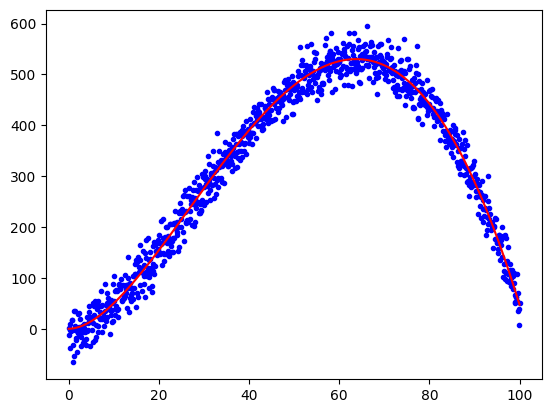

In [2]:
def get_gt(x, noise=True):
    """
    Obtain the ground truth value t for an input feature with value x.
    Note that there is some noise in t, unless excluded.

    Parameters:
        `x`     - a numpy array of input features
                  the values should be between 0 and 100
        `noise` - whether to include noise

    Returns: The target `t` corresponding to each `x`. This is a np.array
             with the same shape as `x`
    """
    # the target is a polynomial function o the input data, plus noise
    t = x**2 - 0.25 * x**2.3 + int(noise) * np.random.normal(0, 25, size=x.shape)
    return t

# generate input data that covers the range that we support: [0, 100]
xs_all       = np.linspace(0,100,1000)
ts_all       = get_gt(xs_all)
ts_noiseless = get_gt(xs_all, noise=False)
plt.plot(xs_all, ts_all, 'b.')      # data with noise
plt.plot(xs_all, ts_noiseless, 'r') # data without noise

You can see that our data is obviously structured and it looks more or less like
it follows a quadratic curve. But the structure may be a little hard to determine
if we only have a few samples in hand, since the small number of samples
may not accurately reflect data variation across the entire set.

To illustrate, let's start with one more function that will sample a small
number of data points (both input + output features):

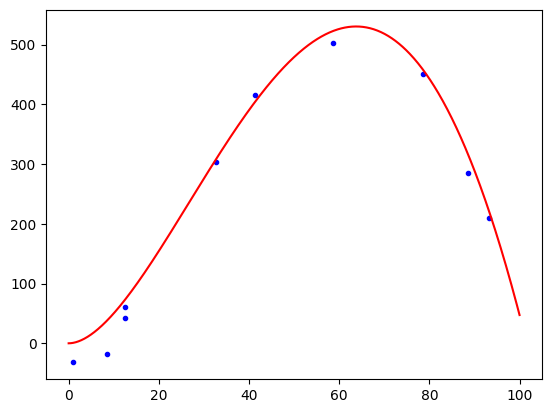

In [3]:
def sample_data(size):
    """
    Sample data points from our distribution.

    Parameters:
        `size`    - represents the np.array size of both the input and targets

    Returns: A tuple `(xs, ts)`, both numpy arrays with shape provided by `size`
    """
    xs = np.random.uniform(0, 100, size=size)
    return xs, get_gt(xs)

# generate a small number of input data, which may not reflect
# the data variation across the entire dataset
xs, ts  = sample_data(size=(10,))
plt.plot(xs, ts, 'b.') # data with noise
plt.plot(xs_all, ts_noiseless, 'r') # data without noise

Now, we will explore the sources of error when we learn a polynomial regression
model from a data sample. First, we will use some `sklearn` functions to perform
the feature mapping transformations.

In [4]:
from sklearn.preprocessing import PolynomialFeatures

M    = 2                     # the degree of our polynomial
poly = PolynomialFeatures(M) # feature mapping fn

xs_fets_all = poly.fit_transform(np.array(xs_all).reshape(-1, 1))
print(xs_all.shape)      # should be (1000,)
print(xs_fets_all.shape) # should be (1000, M+1)
print(xs_fets_all)

(1000,)
(1000, 3)
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00100100e-01 1.00200300e-02]
 [1.00000000e+00 2.00200200e-01 4.00801202e-02]
 ...
 [1.00000000e+00 9.97997998e+01 9.96000004e+03]
 [1.00000000e+00 9.98998999e+01 9.97999000e+03]
 [1.00000000e+00 1.00000000e+02 1.00000000e+04]]


With the feature mapping in place, we can see what a polynomial model
built on these data points look like below.
The blue curve is the quadratic that we fitted to our samples.  The red curve is
the true, noiseless distribution of targets.  We might not be that far off with our
predictions, but you should be able to see that our predictions will vary quite
a bit depending on *which* ten samples we happen to have used to inform our
model.

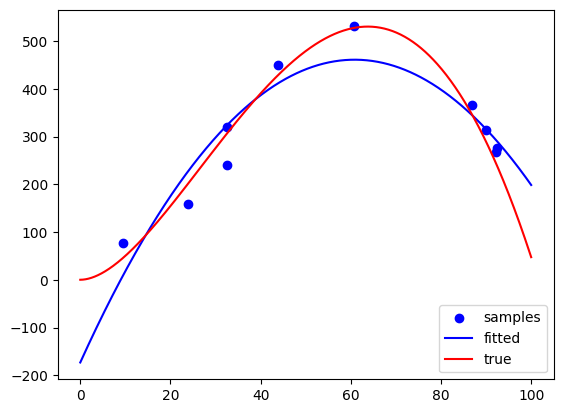

In [5]:
from sklearn.linear_model import LinearRegression

# sample data points
xs, ts = sample_data(size=(10,))
xs_fets = poly.fit_transform(xs.reshape(-1, 1))

# fit the polynomial regression model
pm = LinearRegression().fit(xs_fets, ts)

# plotting
plt.scatter(xs, ts, color='b', marker='o', label='samples')
plt.plot(xs_all, pm.predict(xs_fets_all), color='b', label='fitted') # fitted curve
plt.plot(xs_all, ts_noiseless, 'r', label='true') # noiseless distribution of targets
plt.legend(loc="lower right")

Let's repeat this process several times to better understand how sensitive our models are to the data we select.

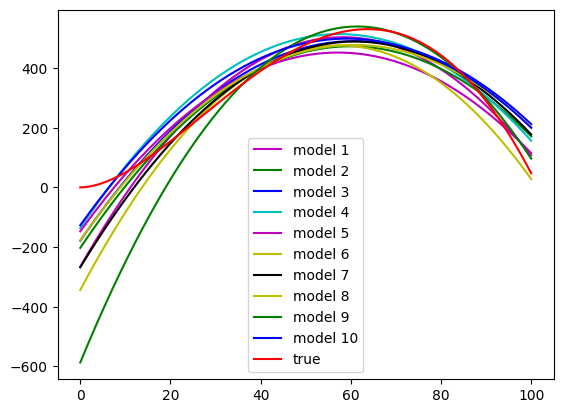

In [6]:
colors = ['m','g','b','c','m','y','k','y','g','b'] #different color for each model fit

for i in range(0, 10):
    # sample data points
    xs, ts = sample_data(size=(10,))
    xs_fets = poly.fit_transform(xs.reshape(-1, 1))
    # fit the polynomial regression model
    pm = LinearRegression()
    pm.fit(xs_fets, ts)
    # plot the result
    plt.plot(xs_all, pm.predict(xs_fets_all), color=colors[i], label=f'model {i+1}')

plt.plot(xs_all, ts_noiseless, 'r', label='true') #noiseless distribution of targets
plt.legend(loc="lower center")

This graph shows us that, while each model we have trained may fit the samples
we selected, none reflect the true distribution of targets perfectly.  We attribute
errors related to the sensitivity of our models to their training data to **variance**.
The more error that is attributable to variance, the more our model has **overfit**
our training data and the less we may expect its performance to generalize.

In fact, we have the following decomposition:
$$\mathbb{E}[ (y - t)^2 | {\bf x}] = (\mathbb{E}[y_\star - y | {\bf x}])^2 + \mathrm{Var}(y | {\bf x})  + \mathrm{Var}(t | {\bf x})$$
Where
- $y_\star = \mathbb{E}[t | {\bf x}]$ is the optimal prediction.
- $\mathbb{E}[ (y - t)^2 ]$ is the total error
- $(\mathbb{E}[y_\star - y | {\bf x}])^2$ is the bias
- $\mathrm{Var}(y | {\bf x})$ is the variance
- $\mathrm{Var}(t | {\bf x})$ is the irreducible error or Bayes error.

Let us reconstruct this decomposition numerically. First, just like in class,
we will fix a value of ${\bf x}$ for our decomposition. This ${\bf x}$ is the test
sample that we would like to make predictions for. We will call this test sample
`x0`.  This is an arbitrary choice, and you are welcome to change this value
and re-run this demonstration!

In [7]:
x0 = np.array([10]) # choose x = 10 as our test sample

Now, let's estimate the quantities $\mathbb{E}[ (y - t)^2 ]$,
$(\mathbb{E}[y_\star - y | {\bf x}])^2$, $\mathrm{Var}(y | {\bf x})$, and
$\mathrm{Var}(t | {\bf x})$ for our choice of ${\bf x}$.

To estimate these quantities, we will need to sample several different
predictions $y$ for our choice of ${\bf x}$. Thus, we will need to perform
the sampling and model building noise several times---let's say ~1000---and
then obtain a prediction for each of these models.

In [8]:
NUM_MODELS = 1000  # number of models we will build
models = [LinearRegression() for i in range(NUM_MODELS)]
ys = []

for model in models:
    xs, ts = sample_data(size=(10,))                 # sampling
    xs_fets = poly.fit_transform(xs.reshape(-1, 1))  # feature mapping
    model.fit(xs_fets, ts) # model fitting
    # obtain a prediction:
    y = model.predict(poly.fit_transform(x0.reshape(-1, 1)))
    ys.append(y)
ys = np.array(ys)

print(ys) # print the predictions from the 1000 models

[[-7.95788104e+00]
 [-6.22985168e+00]
 [-4.81320167e+01]
 [ 2.44035916e+01]
 [ 1.06908500e+02]
 [ 6.96318849e+01]
 [-8.91053722e+01]
 [ 3.83553116e+01]
 [ 9.39685139e+01]
 [ 3.35180366e+01]
 [ 1.00665135e+02]
 [ 9.46419581e+01]
 [-3.58285515e+02]
 [-3.81757961e+01]
 [-1.87454402e+02]
 [-4.36246202e+00]
 [-9.82520609e+01]
 [ 1.15730972e+01]
 [ 7.32438014e+01]
 [-7.14909200e+01]
 [ 7.63603393e+01]
 [-9.58645238e+01]
 [ 5.53875133e+01]
 [-2.70907214e+01]
 [-1.79467650e+02]
 [ 7.23632862e+01]
 [-1.55585050e+02]
 [ 2.32771776e+01]
 [ 7.96592657e+01]
 [ 2.15381258e+01]
 [-8.76574571e+01]
 [ 1.75131992e+01]
 [ 8.49607571e+01]
 [ 1.05408592e+02]
 [ 9.57054250e+01]
 [ 1.23977367e+02]
 [ 9.57761245e+01]
 [ 5.52668784e+01]
 [ 8.31193209e+01]
 [ 9.93158443e+01]
 [ 6.71528528e+01]
 [-3.15811248e+02]
 [ 5.23810660e+01]
 [ 9.18009842e+01]
 [ 6.81074524e+01]
 [ 5.94656577e+01]
 [-1.15651467e+02]
 [ 3.56344095e+01]
 [ 8.13807572e+01]
 [ 7.72727291e+01]
 [ 4.94660027e+01]
 [ 7.61512272e+01]
 [ 1.0312146

This is enough for us to estimate the **variance** of our model at `x0` using these
estimates $y_i$s, where each $y_i$ is the prediction made from the $i$th
model:

In [9]:
print("Variance:", np.var(ys))

Variance: 8360.297225450135


Now, $y_\star = \mathbb{E}[t | {\bf x}]$, the optimal prediction we
can make, can be computed using our data generation distribution. (The
benefit of using synthetic data is our ability to access values like this
one.)
Thus, we can also estimate the **bias** of our model at `x0`:

In [10]:
y_star = get_gt(x0, noise=False)
print("Bias", np.mean(ys - y_star) ** 2)

Bias 1651.736588106407


Finally, we can either estimate the Bayes error, or read it
directly from the way `get_gt` is implemented.

**Task**: What is the (theoretical) Bayes error, which we can
read directly from the way `get_gt` is implemented? You might find it helpful
to look up the parameters of the `np.random.normal` function.

In [11]:
# TODO
# The theoretical Bayes error is 625, this is directly read from the
# np.random.normal(0, 25, ...) call in get_gt.

We can also produce an empirical estimate by sampling a ground-truth
value corresponding to `x0` some number of times. We will use the latter
approach, since the sampled ground-truth values will be useful for computing
the total error as well.

In [27]:
ts_resample = get_gt(np.repeat(x0, NUM_MODELS)) # sample ts NUM_MODELs times
print("Bayes Error:", np.var(ts_resample)) # empirical estimate

print("SUM of bias + variance + bayes error:", np.var(ys) + np.mean(ys - y_star) ** 2 + np.var(ts_resample))

Bayes Error: 614.5662652840655
SUM of bias + variance + bayes error: 3764.1653211914495


Now, let us estimate the total error, by comparing the predictions `ys`
from above with the sampled ground-truth values `ts_resample`. This should
be fairly close to the total above.

In [28]:
print("Total Error:", np.mean((ys - ts_resample) ** 2))

Total Error: 3763.0889754491495


In case you would like experiment a bit (e.g., with different values of `x0`),
here's the above code put in a single cell.

In [14]:
M = 2
x0 = np.array([25])
NUM_MODELS = 1000  # number of models we will build

poly = PolynomialFeatures(M)
models = [LinearRegression() for i in range(NUM_MODELS)]
ys = []
for model in models:
    xs, ts = sample_data(size=(10,))                 # sampling
    xs_fets = poly.fit_transform(xs.reshape(-1, 1))  # feature mapping
    model.fit(xs_fets, ts) # model fitting
    # obtain a prediction:
    y = model.predict(poly.fit_transform(x0.reshape(-1, 1)))
    ys.append(y)
ys = np.array(ys)

y_star = get_gt(x0, noise=False)
ts_resample = get_gt(np.repeat(x0, NUM_MODELS)) # sample ts NUM_MODELs times


print("Bias", np.mean(ys - y_star) ** 2)
print("Variance:", np.var(ys))
print("Bayes Error:", np.var(ts_resample), f"(theoretical value: {25**2})")
print("SUM of bias + variance + bayes error:", np.var(ys) + np.mean(ys - y_star) ** 2 + np.var(ts_resample))
print("Total Error:", np.mean((ys - ts_resample) ** 2))

Bias 1874.3419894010392
Variance: 1805.1592136968836
Bayes Error: 605.9271757079678 (theoretical value: 625)
SUM of bias + variance + bayes error: 4285.428378805891
Total Error: 4242.352123781554


Let's see how bias and variance change as we change the complexity of our model.
In this synthetic example, we will define complexity by the degree of the polynomial
that we use to model our data.

**Task**: Complete the code below to provide an
empirical estimate of the bias, variance, Bayes error,
and total error.

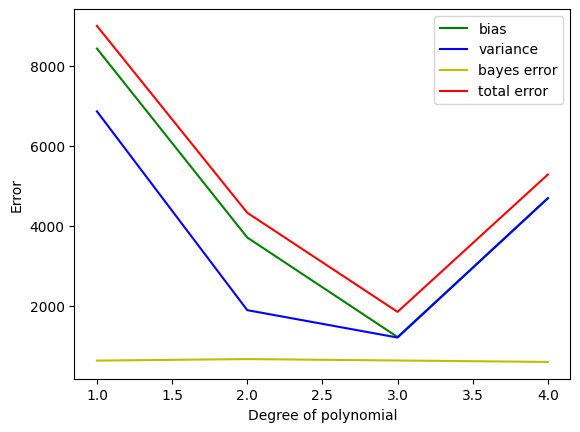

In [29]:
NUM_MODELS = 1000
x0 = np.array([25])  # note: we could also average over a range of xsfor this analysis!
degrees = [1, 2, 3, 4]

bias, variance, bayes, total = [], [], [], []

for M in degrees:
    poly = PolynomialFeatures(M)
    models = [LinearRegression() for i in range(NUM_MODELS)]
    ts_resample = get_gt(np.repeat(x0, NUM_MODELS))

    ys = []
    for model in models:
        xs, ts = sample_data(size=(10,))                 # sampling
        xs_fets = poly.fit_transform(xs.reshape(-1, 1))  # feature mapping
        model.fit(xs_fets, ts) # model fitting
        # obtain a prediction:
        y = model.predict(poly.fit_transform(x0.reshape(-1, 1)))
        ys.append(y)
    ys = np.array(ys)

    y_star = get_gt(x0, noise=False)

    # compute the bias, variance, bayes error, and total error for
    # the current choice of max degree M
    bias_value = np.mean((ys - y_star)**2) # TODO
    variance_value = np.var(ys) # TODO
    bayes_value = np.var(ts_resample) # TODO
    total_value = np.mean((ys - ts_resample)**2) # TODO

    bias.append(bias_value)
    variance.append(variance_value)
    bayes.append(bayes_value)
    total.append(total_value)

plt.plot(degrees, bias, 'g', label='bias')
plt.plot(degrees, variance, 'b', label='variance')
plt.plot(degrees, bayes, 'y', label='bayes error')
plt.plot(degrees, total, 'r', label='total error')
plt.xlabel("Degree of polynomial")
plt.ylabel("Error")
plt.legend()
plt.show()

**Task**: Based on the figure above, explain how the bias
and variance of the model changes depending on the choice of $M$.

In [16]:
# TODO
# Increasing M reduces bias but increases variance.
# Very simple models underfit, very complex models overfit.
# The total error reflects the combination of bias, variance, and irreducible
# noise, showing an optimal model complexity in the middle.

**Task**: Note that our choice of the number of training
samples to use to build each model affects the variance of the
model as well! How do you think the variance of our models will
change if we *increase* the number of training samples (e.g., from
10 to 100 or even 1000).

In [17]:
# TODO
# The variance will be reduced.

People often assume that, as a rule, bias falls and variance increases as model complexity increases.
This can lead to accuracy profiles that are shaped like a "U". In the case above, a "U" shape
is somewhat clear.  However, "U" shaped error profiles are not always a given!! Empirical results
with neural networks, in fact, show that errors may keep decreasing as networks, and the parameters
associated with them, become wide. This suggests that there might not be a bias-variance tradeoff
in neural networks with respect to network width, unlike was originally claimed by
[important authors in the ML space](https://www.dam.brown.edu/people/documents/bias-variance.pdf).

If you are interested in learning more about this topic,
we suggest you look at this recent paper by [Neal et. al](https://arxiv.org/abs/1810.08591).

## Part 2. Using real data to examine Bias and Variance

Now let's continue our bias/variance analysis on real data that we have seen in the past,
and using some of the models that we have learned thus far.
As before we will be focusing on NHANES survey data relevant to the assessment of heart disease.
We again refer you to the [NHANES data dictionary](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx)
to better understand the data. We will not repeat the exploratory data analysis from lab 1,
but encourage you to review the data definition and key summary.

- `gender` (RIAGENDR): which is binary 2=female, 1=male
- `race_ethnicity` (RIDRETH3): which can be 1=mexican american, 2=other hispanic, 3=white, 4=black, 6=asian, ...
- `age` (RIDAGEYR): Age in years
- `drink_alcohol` (ALQ101): which is binary; 1 indicates the individual reportedly drinks alcohol and 2 indicates they do not
- `blood_cholesterol` (LBDTCSI): Results of an individual's blood cholesterol tests (mmol of cholesterol/L of blood)
- `blood_pressure_sys` (BPXSY1): an individual's systolic blood pressure
- `diastolic_bp` (BPXDI1): an individual's diastolic blood pressure
- `calories` (DR1TKCAL): the number of calories an individual eats per day
- `BMI` (BMXBMI): an individual's Body Mass Index (which can be used to assess obesity)
- `chest_pain_ever` (CDQ001): If an individual has ever reported chest pain.
- `family_income` (INDFMPIR): Ratio of a family's income to poverty threshold

We will be using these features to predict the column `target_heart`:

- `target_heart`: An individual reports that they have heart disease (1=yes, 0=no).

In [30]:
!wget https://URL/TO/NHANES-heart.csv

--2025-09-18 16:30:00--  https://url/TO/NHANES-heart.csv
Resolving url (url)... failed: Name or service not known.
wget: unable to resolve host address ‘url’


In [31]:
# read a csv file as a *pandas data frame*
data = pd.read_csv("NHANES-heart.csv")

# display a dataframe
data.describe()

,gender,race_ethnicity,chest_pain_ever,drink_alcohol,age,BMI,weight_kg,blood_pressure_sys,diastolic_bp,blood_cholesterol,calories,family_income,target_heart
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,1.498375,3.222000,1.649125,1.304375,62.627875,25.352687,61.112887,117.135500,65.705000,4.584376,1866.986875,2.456017,0.500000
std,0.500029,1.330672,0.477274,0.460171,12.225806,7.683466,32.803242,15.050115,11.610893,0.908403,867.494312,1.532800,0.500031
min,1.000000,1.000000,1.000000,1.000000,40.000000,12.900000,3.300000,82.000000,0.000000,2.020000,171.000000,0.000000,0.000000
25%,1.000000,3.000000,1.000000,1.000000,52.000000,19.700000,33.600000,108.000000,60.000000,4.090000,1337.750000,1.180000,0.000000
50%,1.000000,3.000000,2.000000,1.000000,63.000000,24.600000,63.700000,116.000000,66.000000,4.500000,1735.000000,2.050000,0.500000
75%,2.000000,4.000000,2.000000,2.000000,73.000000,29.500000,83.000000,122.000000,72.000000,4.970000,2215.250000,3.800000,1.000000
max,2.000000,7.000000,2.000000,2.000000,80.000000,82.900000,201.600000,220.000000,116.000000,11.970000,8496.000000,5.000000,1.000000


Like in lab 1 and 2, we will use indicator features for categorical values and add a bias parameter in our model.

In [32]:
feature_names = [
    "gender_female",
    "re_hispanic",
    "re_white",
    "re_black",
    "re_asian",
    "chest_pain",
    "drink_alcohol",
    "age",
    "blood_cholesterol",
    "BMI",
    "blood_pressure_sys",
    "diastolic_bp",
    "calories",
    "family_income"]

data_fets = np.stack([
    data["gender"] == 2,
    (data["race_ethnicity"] == 1) + (data["race_ethnicity"] == 2),
    data["race_ethnicity"] == 3,
    data["race_ethnicity"] == 4,
    data["race_ethnicity"] == 6,
    data["chest_pain_ever"] == 2,
    data["drink_alcohol"] == 2,
    data["age"],
    data["blood_cholesterol"],
    data["BMI"],
    data["blood_pressure_sys"],
    data["diastolic_bp"],
    data["calories"],
    data["family_income"]
], axis=1)

print(data_fets.shape) # Should be (8000, 14)

(8000, 14)


Like before, we can separate our data into training, validation, and test sets.
We will use the same code as we did in lab 1. Just like in lab 1, we will
normalize our data set since some of the classifiers we use will depend on it.

In [33]:
from sklearn.model_selection import train_test_split

# Split the data into X (dependent variables) and t (response variable)
X = data_fets
t = np.array(data["target_heart"])

# First, we will use `train_test_split` to split the data set into
# 6500 training+validation, and 1500 test:
X_tv, X_test, t_tv, t_test = train_test_split(X, t, test_size=1500/8000, random_state=1)

# Then, use `train_test_split` to split the training+validation data
# into 5000 train and 1500 validation
X_train, X_valid, t_train, t_valid= train_test_split(X_tv, t_tv, test_size=1500/6500, random_state=1)

# Normalization
numerical_value_start = 7
mean = X_train[:, numerical_value_start:].mean(axis=0)
std = X_train[:, numerical_value_start:].std(axis=0)

X_train_norm = X_train.copy()
X_valid_norm = X_valid.copy()
X_test_norm = X_test.copy()
X_train_norm[:, numerical_value_start:] = (X_train[:, numerical_value_start:] - mean) / std
X_valid_norm[:, numerical_value_start:] = (X_valid[:, numerical_value_start:] - mean) / std
X_test_norm[:, numerical_value_start:] = (X_test[:, numerical_value_start:] - mean) / std

Now, we are ready to build some models to understand the various sources of error.
We will work with these three classifiers, which we have previously experimented with.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

**Task**:
Unlike with synthetic data, we will not be able to produce empirical estimates of
the bias and the Bayes error. Why is that? Why is it that we *are* able to
estimate the variance of our classifier?

In [23]:
# TODO
# With real data, we cannot estimate bias or Bayes error because the true
# underlying relationship between features and the target is unknown, and the
# irreducible noise cannot be separated from the signal. However, we can
# estimate variance by training the model on different subsets of the data and
# measuring how much the predictions vary.

**Task**: Complete the function below, which fits a classifier several
times, each time sampling a small training set (without replacement) from
`X_train_norm`.

In [35]:
def estimate_variance(model, ntries=100, nsample=200):
    """
    Estimate the variance of a classifier on the NHANES data set.

    Parameters:
        `model` - an sklearn model supporting the methods fit(),
                  predict(), and score()
        `ntries` - number of times to train the classifier to compute
                   the classifier's variance.
        `nsamples` - number of data points to sample to train each
                     classifier

    Returns: A tuple containing the average training error,
             average validation error, and variance estimate.
    """
    train_acc = []
    val_acc = []
    ys = []
    for i in range(ntries):
        subset = random.sample(range(5000), nsample)
        model.fit(X_train_norm[subset], t_train[subset])
        ys.append(model.predict(X_valid_norm))
        train_acc.append(model.score(X_train_norm[subset], t_train[subset]))
        val_acc.append(model.score(X_valid_norm, t_valid))
    ys = np.stack(ys)
    variances = np.var(ys, axis=0) # TODO: Compute the variance of each row of ys, i.e., for
                     #       each validation data point separate. (Why? Why can't
                     #       we compute the variance of the entire ys?)
    train_error = 1 - np.mean(train_acc) # TODO: the average training error across the ntries models
    val_error = 1 - np.mean(val_acc) # TODO: the average validation error across the ntries models
    return train_error, val_error, variances.mean()

Now, we will use this function to see how the training error, validation error, and
variance changes with our choice of hyper-parameters.

**Task**: The `LogisticRegression` classifier model has a parameter `C`.
Read the sklearn API documentation and explain what this parameter `C` does, assuming
that L2 regularization is used.

In [25]:
# TODO
# In LogisticRegression with L2 regularization, the parameter C controls the
# strength of regularization: smaller C means stronger regularization (simpler
# model, higher bias, lower variance), while larger C means weaker
# regularization (more complex model, lower bias, higher variance).

**Task**: Run the code below to explore how the `C` parameter
of a `LogisticRegression` affects the training error, validation error,
and variance.

In [36]:
cs_res = []
cs = np.arange(-5, 2, 0.2)

for c_exp in cs:
    model = LogisticRegression(random_state=0, penalty='l2', C=10**(c_exp))
    train_error, val_error, variance = estimate_variance(model)
    cs_res.append([train_error, val_error, variance])

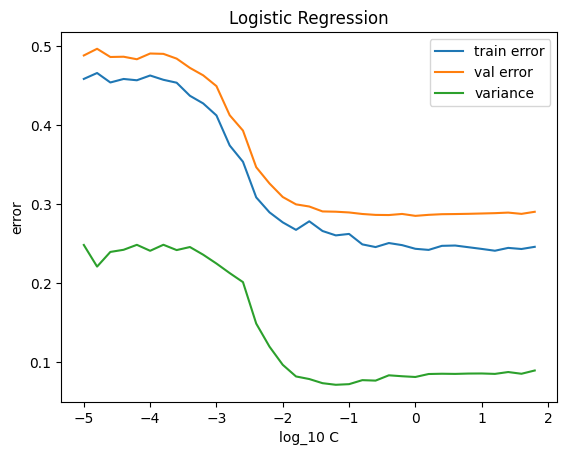

In [37]:
plt.title("Logistic Regression")
plt.plot(cs, [r[0] for r in cs_res], label="train error")
plt.plot(cs, [r[1] for r in cs_res], label="val error")
plt.plot(cs, [r[2] for r in cs_res], label="variance")
plt.ylabel("error")
plt.xlabel("log_10 C")
plt.legend()
plt.show()

**Task**: How does the `C` parameter affect the training error, validation error,
and variance of the trained model?

In [ ]:
# TODO
# All the errors decrease with the C parameter, and the variance does as well.

**Task**: Run the code below, which explores how the number of hidden units
in a 2-layer neural network affects training error, validation error,
and variance.
(You might get some `Stochastic Optimizer` errors saying that the optimization
have not converged. Please ignore those.
We are also reducing `ntries` so this code runs faster.)

In [38]:
mlp_res = []
hidden_sizes = range(1, 21)

for h in hidden_sizes:
    model = MLPClassifier(alpha=0,                 # set regularization parameter to 0
                          hidden_layer_sizes=(h,), # use only 1 hidden layer with h units
                          learning_rate_init=0.1,  # increase LR from the default
                          max_iter=200)
    train_error, val_error, variance = estimate_variance(model, ntries=10)
    mlp_res.append([train_error, val_error, variance])

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

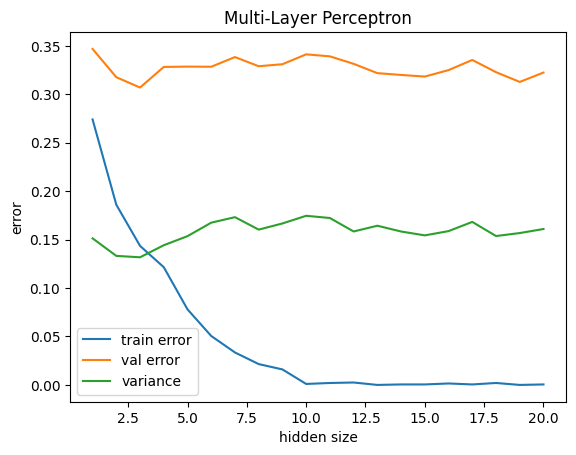

In [39]:
plt.title("Multi-Layer Perceptron")
plt.plot(hidden_sizes, [r[0] for r in mlp_res], label="train error")
plt.plot(hidden_sizes, [r[1] for r in mlp_res], label="val error")
plt.plot(hidden_sizes, [r[2] for r in mlp_res], label="variance")
plt.ylabel("error")
plt.xlabel("hidden size")
plt.legend()
plt.show()

**Task**: How does the number of units in the hidden size affect the
training error, validation error, and variance of the trained model?

In [ ]:
# TODO
# Few hidden units → high bias, low variance, higher training error

# Moderate hidden units → balanced bias and variance, lower validation error

# Many hidden units → low bias, high variance, very low training error but
# potentially higher validation error

**Task**: Run the code below to explore how the `max_depth` parameter
of a `DecisionTreeClassifier` affects the training error, validation error,
and variance.

In [40]:
tree_res = []
depths = list(range(1,21))
for max_depth in depths:
    model = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    train_error, val_error, variance = estimate_variance(model)
    tree_res.append([train_error, val_error, variance])

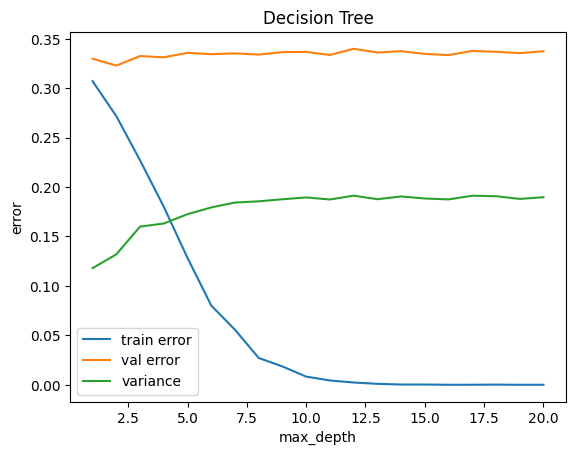

In [41]:
plt.title("Decision Tree")
plt.plot(depths, [r[0] for r in tree_res], label="train error")
plt.plot(depths, [r[1] for r in tree_res], label="val error")
plt.plot(depths, [r[2] for r in tree_res], label="variance")
plt.ylabel("error")
plt.xlabel("max_depth")
plt.legend()
plt.show()

**Task**: How does the `max_depth` parameter affect the training error, validation error,
and variance of the trained model?

In [ ]:
# TODO
# Small max_depth → high bias, low variance, higher training error

# Moderate max_depth → balanced bias and variance, lower validation error

# Large max_depth → low bias, high variance, very low training error but higher
# validation error

We saw in lab 1 that hyperparameters interact with each other in
unpredictable ways (e.g., max depth, min split, and the split criteria
for a decision tree classifier). The analysis we conduct in this
lab focuses on a single hyperparameter at a time, but keep in
mind that a **grid search** is required to properly tune sets of
hyperparameters.

## Part 3. Ensemble Methods

**Ensemble methods** is a family of ideas that involve
averaging together the predictions of many models, instead
of using a single model.
In this section, we will analyze the impact of model averaging,
and explore the `RandomForest` classifier.

**Task**: Complete the function below, which is a modification
of the `estimate_variance` function, that computes the

In [44]:
def model_averaging(model, ntries=100, nsample=200):
    """
    Fits model a number of times on a subset of the NHANES data
    set, and returns the average validation error of the
    individual models, along with the validation error of the
    average prediction of the models.

    Parameters:
        `model` - an sklearn model supporting the methods fit(),
                  predict(), and score()
        `ntries` - number of times to train the classifier
        `nsamples` - number of data points to sample to train each
                     classifier

    Returns: A tuple containing the average validation error
             across the individual models, and the validation
             error of the average prediction of the models.
    """

    train_acc = []
    val_acc = []
    ys = []
    for i in range(ntries):
        subset = random.sample(range(5000), nsample)
        model.fit(X_train_norm[subset], t_train[subset])
        ys.append(model.predict(X_valid_norm))
        train_acc.append(model.score(X_train_norm[subset], t_train[subset]))
        val_acc.append(model.score(X_valid_norm, t_valid))
    ys = np.stack(ys)

    # compute the average validation error across the individual models
    avg_val_error = 1 - np.mean(val_acc)

    # compute the average prediction across all models, and convert
    # into a discrete prediction (0 or 1 for each data point in the
    # validation set)
    ys_average = np.mean(ys, axis=0)
    ys_average_discrete = (ys_average >= 0.5).astype(int)


    # compute the validation error using ys_average and t_valid
    ensemble_val_error  = np.mean(ys_average_discrete != t_valid)

    return avg_val_error, ensemble_val_error

**Task**: Run the code below, which uses the function we wrote to
analyze how model averaging affects the validation error.

In [45]:
print("====== Logistic Regression Models ======")
cs = np.arange(-5, 2, 0.2)
for c_exp in cs:
    model = LogisticRegression(random_state=0, penalty='l2', C=10**(c_exp))
    avg_val_error, ensemble_val_error = model_averaging(model)
    print(f"C=10**{c_exp}", avg_val_error, ensemble_val_error)

====== Logistic Regression Models ======
C=10**-5.0 0.48650000000000004 0.502
C=10**-4.8 0.4968866666666668 0.502
C=10**-4.6 0.49229333333333347 0.498
C=10**-4.3999999999999995 0.4924133333333335 0.502
C=10**-4.199999999999999 0.47992 0.28933333333333333
C=10**-3.999999999999999 0.4921066666666667 0.502
C=10**-3.799999999999999 0.48548 0.318
C=10**-3.5999999999999988 0.49171333333333334 0.502
C=10**-3.3999999999999986 0.4580533333333334 0.44133333333333336
C=10**-3.1999999999999984 0.4637266666666666 0.318
C=10**-2.9999999999999982 0.4391666666666666 0.288
C=10**-2.799999999999998 0.43124000000000007 0.296
C=10**-2.599999999999998 0.3771133333333334 0.28733333333333333
C=10**-2.3999999999999977 0.34327333333333343 0.282
C=10**-2.1999999999999975 0.3222533333333333 0.2813333333333333
C=10**-1.9999999999999973 0.3129133333333334 0.2793333333333333
C=10**-1.7999999999999972 0.3014 0.2833333333333333
C=10**-1.599999999999997 0.2972 0.2806666666666667
C=10**-1.3999999999999968 0.29316 0.280

In [46]:
print("====== Decision Trees ======")
depths = list(range(1,21))
for max_depth in depths:
    model = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
    avg_val_error, ensemble_val_error = model_averaging(model)
    print(f"max_depth={max_depth}", avg_val_error, ensemble_val_error)

====== Decision Trees ======
max_depth=1 0.33358 0.29933333333333334
max_depth=2 0.32292 0.2793333333333333
max_depth=3 0.3300400000000002 0.264
max_depth=4 0.33688666666666667 0.26066666666666666
max_depth=5 0.33342666666666654 0.23466666666666666
max_depth=6 0.3343666666666667 0.216
max_depth=7 0.3406133333333333 0.22133333333333333
max_depth=8 0.33902 0.198
max_depth=9 0.33499333333333337 0.20133333333333334
max_depth=10 0.33816 0.20466666666666666
max_depth=11 0.3353533333333335 0.19666666666666666
max_depth=12 0.33266666666666667 0.20666666666666667
max_depth=13 0.3382733333333333 0.20333333333333334
max_depth=14 0.3356133333333333 0.19466666666666665
max_depth=15 0.3370466666666665 0.20466666666666666
max_depth=16 0.3372533333333334 0.19533333333333333
max_depth=17 0.33609999999999995 0.18933333333333333
max_depth=18 0.33963333333333334 0.20666666666666667
max_depth=19 0.34140000000000015 0.20133333333333334
max_depth=20 0.3387399999999998 0.192


In [ ]:
# The MLP code is also included. You can optionally uncomment
# and run this code for your interest. However, these models tend to be more
# expensive to train, and are less often used in an ensemble.

# print("====== MultiLayer Perceptrons  ======")
# hidden_sizes = range(1, 21)
# for h in hidden_sizes:
#     model = MLPClassifier(alpha=0,  # regularization parameter
#                           hidden_layer_sizes=(h,),
#                           learning_rate_init=0.01,
#                           max_iter=200)
#     avg_val_error, ensemble_val_error = model_averaging(model, ntries=10)
#     print(f"hidden_size={h}", avg_val_error, ensemble_val_error)

**Task**: Analyze the pattern above.
You should see that ensemble models tend to
perform better or the individual models.
Discuss the patterns you see as to which models tend to achieve
lower validation error in an ensemble,
and the amount of variance and total error that these models tend
to have (from the previous results).

In [ ]:
# Ensembles reduce variance and improve validation performance, especially for
# complex, high-variance models like deep decision trees. This illustrates why
# Random Forests and other bagging approaches are so effective in practice.

# For max_depth = 5, the average validation error of individual trees was
# 0.2347, while the ensemble validation error dropped to 0.216.

# For a deeper tree, max_depth = 20, the individual trees had an average
# validation error of 0.3387, but the ensemble reduced it to 0.192.

You should see that decision trees perform quite well as an ensemble.
While individual trees are rarely used in practice,
an ensemble of trees tend to work well with little
tuning. Let's now explore the `RandomForestClassifier`, which trains
an ensemble of trees, with some additional randomness baked into
the model to make the predictions less correlated.


**Task**: Run the below code, which explores how the number of
individual trees in a random forest classifier affects the
training error, validation error, and variance.

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_res = []
num_trees = [1, 2, 5, 10, 25, 50]
for n in num_trees:
    model = RandomForestClassifier(n_estimators=n)
    train_error, val_error, variance = estimate_variance(model, ntries=10, nsample=1000)
    forest_res.append([train_error, val_error, variance])

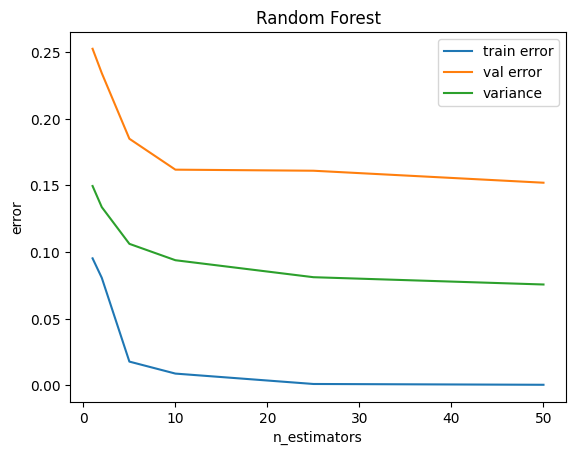

In [48]:
plt.title("Random Forest")
plt.plot(num_trees, [r[0] for r in forest_res], label="train error")
plt.plot(num_trees, [r[1] for r in forest_res], label="val error")
plt.plot(num_trees, [r[2] for r in forest_res], label="variance")
plt.ylabel("error")
plt.xlabel("n_estimators")
plt.legend()
plt.show()

**Task**: How does the number of trees affect the variance
of a random forest classifier?

In [ ]:
# TODO
# Adding more trees to a random forest reduces variance without increasing bias,
# which is why random forests tend to be very stable and perform well with little
# tuning.

**Task**: Finally, run the code below, which trains a random forest
classifier on the entire training set, and computes the training
and validation accuracy.

In [49]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train_norm, t_train)
print("Training Accuracy:", model.score(X_train_norm, t_train))
print("Validation Accuracy:", model.score(X_valid_norm, t_valid))

Training Accuracy: 1.0
Validation Accuracy: 0.9846666666666667


**Task**: As in the synthetic task, the availability of data can
also impact model performance.
Explain how changing the amount of training data would affect model
performance.

In [ ]:
# TODO: Explanation of different amounts of training data has on model performance, bias/variance.
# More training data → lower variance, better generalization; less training
# data → higher variance, higher risk of overfitting.

In reality, there are many more factors that can affect model performance.
Training models, especially in healthcare, can be a difficult process. In
this lab you relied on training and validation accuracy as a measure of
model performance. But relying on just accuracy as a metric does perfectly
reflect if a certain model is useful or appropriate.

In healthcare, we care about minimizing errors that are more dangerous to
our patients, and de-prioritize errors that have little known adverse effect.
Similarly, there can be other factors to take into account when making
decisions. A certain decision may algorithmically seem like the most
optimal, but we need to take into account a patient's history and
personality. Prescribing a certain intervention may not work on certain
individuals, or certain patients may not be comfortable with certain
decisions regardless of the "accuracy".

Accuracy as a metric has many shortcomings, and a good reference for further
reading can be found [here](https://predictive-optimization.cs.princeton.edu/).
It is important in the future to always consider alternative metrics instead of
solely relying on accuracy.